**Denoising a synthetic signal using the SVD algorithm**

In [296]:
#Importation of necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [297]:
#Generation of synthetic sinus signal
t=np.linspace(0 , 1 , 1000)  #defining time doamin
f=10     #Signal frequency
phi=30    #Phase
A=1      #Amplitude
s=A*np.sin(2*np.pi*f*t+phi)  #Synthetic sinus signal generation

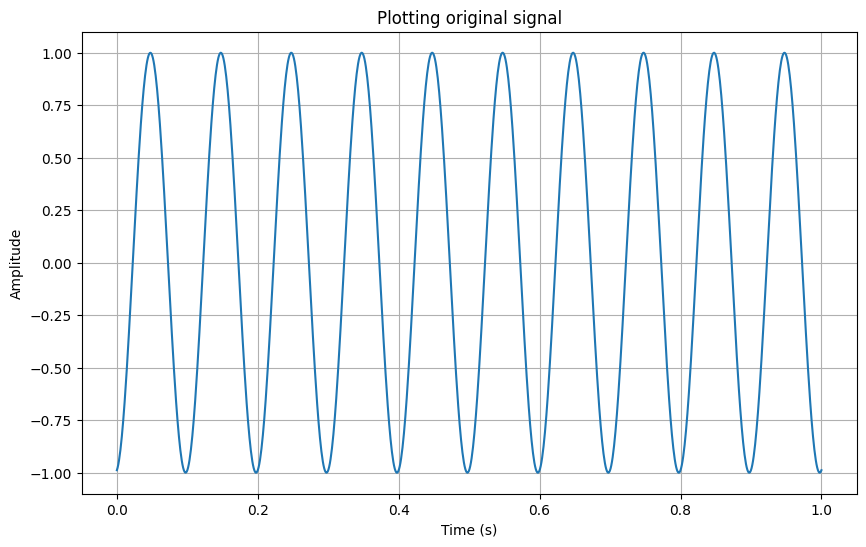

In [298]:
#Plotting original signal
plt.figure(figsize=(10, 6))
plt.plot(t, s)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Plotting original signal')
plt.grid(True)

In [299]:
#Generation of white noise
b=np.random.normal(0, 0.3, len(s)) #A random gaussian noise generation with
                                  #mean=0, std = 0.3, size=len(s)=1000

In [300]:
#Adding noise to the original signal
noisy_s=s+b

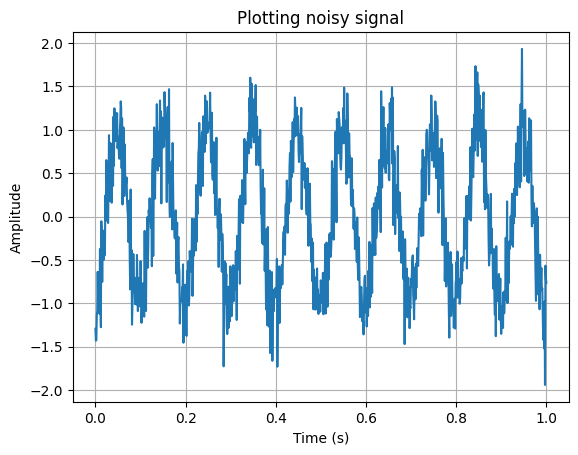

In [301]:
#Plotting noisy signal
plt.figure()
plt.plot(t, noisy_s)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Plotting noisy signal')
plt.grid(True)

In [302]:
#definition of a function that generates hankel matrix
from scipy.linalg import hankel

def create_hankel_matrix (signal, window_size):

  N=len(signal)     #the length of the signal is very important for determining window size

  if window_size > N or window_size < 2 :

    raise ValueError("Window size must be less than signal length and greater than one")

  H=hankel(signal[:window_size], signal[window_size-1:])   #hankel matrix generation
  return H

In [303]:
#Generation of hankel matrix of the noisy signal
H=create_hankel_matrix(noisy_s, len(noisy_s)//2) #window size is chosen of length len(s)//2, in order to get a square like shape

In [304]:
#Application of singular value decomposition
U, S, Vt=np.linalg.svd(H, full_matrices=False)

In [305]:
#generation of a function that Reconstructs denoised signal
def reconstruct_filtered_signal(H):
    rows, cols = H.shape               # Get dimensions of H
    denoised_signal = np.zeros(rows + cols - 1)  # Result array for the 1D signal
    counts = np.zeros(rows + cols - 1)            # To count elements per anti-diagonal

    # Loop over each element of H
    for i in range(rows):
        for j in range(cols):
            denoised_signal[i + j] += H[i, j]    # Add element to corresponding anti-diagonal
            counts[i + j] += 1                    # Increment count for averaging

    # Divide sums by counts to get average per anti-diagonal
    return denoised_signal / counts

In [306]:
#signal to noise ratio for  he noisy signal before filtering
#SNR=10*log10(signal_power/noise_power) assuming that we know the pure signal power
clean_signal_power=np.sum(s**2)  #Pure signal power
noise_power=np.sum(b**2)     #White noise power
snr_original_signal=10*np.log10(clean_signal_power/noise_power)  #Signal to ratio for our original ""noisy"" signal
print(snr_original_signal)

7.426678794449293


In [307]:
#visual inspection method to find optimum top r singular values
"""
We use several metrics to choose the best possible value of r. The method is simple: for different values of r, we filter the signal,
and for each filtered signal, we calculate several evaluation metrics: SNR, MSE, MAE, and residual error.

Next, we normalize and plot these metrics against the r values.
The value of r that gives the optimal metric values is then selected
"""
from sklearn.metrics import mean_squared_error, mean_absolute_error  #Importing evaluation metrics functions (mean squared error, and mean absolute error)

SNR_filtered=[]   #Initializing an empty list for storing different signal to noise ratio values
MSE=[]            #Initializing an empty list for storing different mean squared errors values
MAE=[]            #Initializing an empty list for storing different mean absolute errors values
RESIDUAL=[]       #Initializing an empty list for storing different residual error values
Filtered=[]      #Initializing an empty list for storing filtered signal for different r values

R=np.arange( 1, len(S)//2, 1 )   # Assume the optimal r is usually within the first half of possible values.
                                 # To reduce computation time, we filter the signal using only these first half values.
                                 # If needed, we can extend the search to the second half later.
for r in R:

  #Keeping rank_r approximation of the hankel matrix
  H_r=U[: , :r]@np.diag(S[:r])@Vt[:r, :]

  #Reconstruction of filtered signal for different values of r
  filtered_signal=reconstruct_filtered_signal(H_r)

  #Storing the filtered signals in the empty list Filtered
  Filtered.append(filtered_signal)

  #signal to noise ratio for different r values
  new_noise_power=np.sum((s-filtered_signal)**2)
  snr_filtered_signal=10*np.log10(clean_signal_power/new_noise_power)

  #Storing snr values
  SNR_filtered.append(snr_filtered_signal)

  #Mean squared error for different r values
  mse=mean_squared_error(s, filtered_signal)
  MSE.append(mse)    #Storing mse values

  #Mean absolute error for different values of r
  mae=mean_absolute_error(s, filtered_signal)
  MAE.append(mae)    #Storing mae values

  #Residual error for different values r
  residual=s-filtered_signal
  RESIDUAL.append(np.linalg.norm(residual))   #Storing the norm of rsidual error

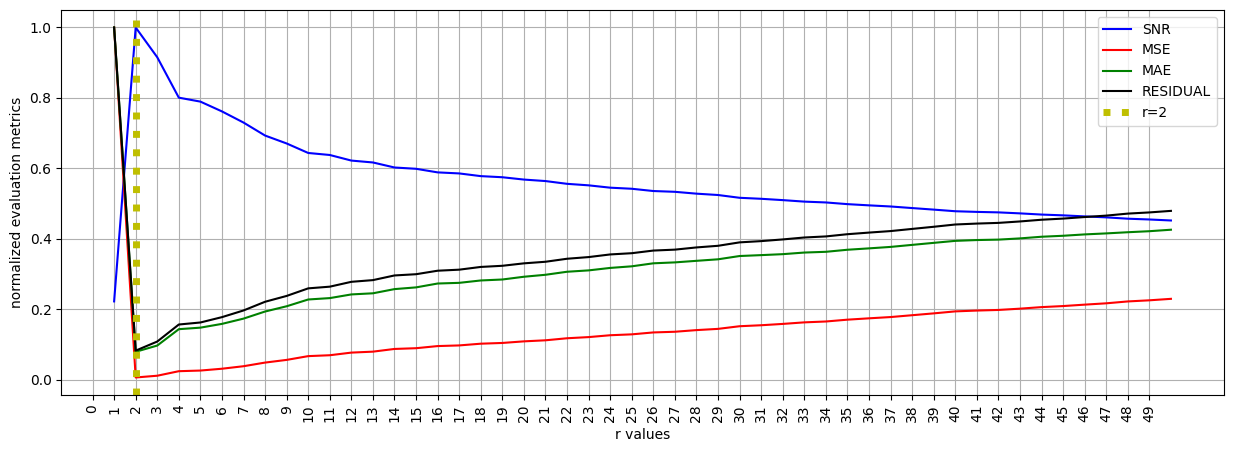

In [308]:
#Plotting different metrics to check the fiability of the r choosing method
plt.figure(figsize=(15 , 5))
plt.plot(R[:50], SNR_filtered[:50]/np.max(np.abs(SNR_filtered)), color='b', label='SNR')   #Plot of the normalized signal to noise ratio value
plt.plot(R[:50], MSE[:50]/np.max(np.abs(MSE)), color='r', label='MSE')                     #Plot of the normalized mean squared error values
plt.plot(R[:50], MAE[:50]/np.max(np.abs(MAE)), color='g', label='MAE')                     #Plot of the normalized mean absolute error values
plt.plot(R[:50], RESIDUAL[:50]/np.max(np.abs(RESIDUAL)), color='black', label='RESIDUAL')  #Plot of the normalized residual error values (the norm )
plt.xticks(np.arange(0 ,50 , 1), rotation=90)
plt.xlabel('r values')
plt.ylabel('normalized evaluation metrics')
plt.axvline(x=2,lw=5,color='y', linestyle='dotted', label='r=2')
plt.grid(True)
plt.legend()

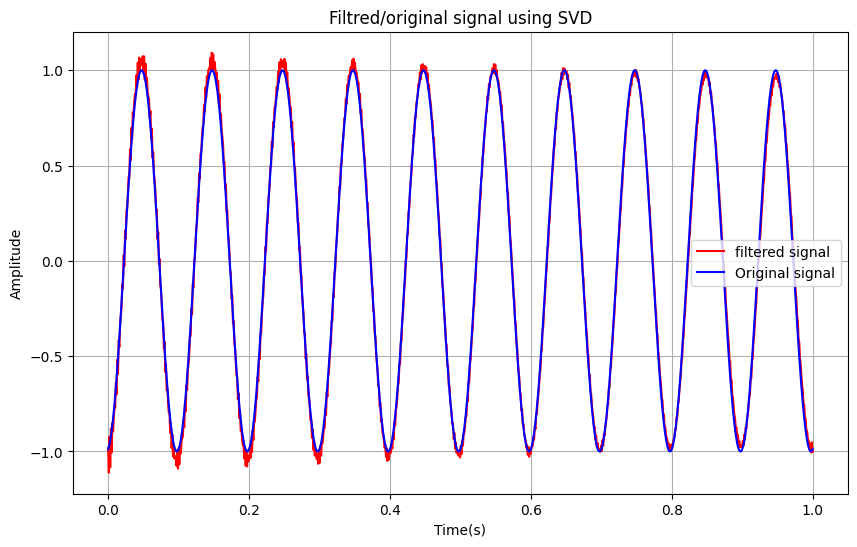

In [309]:
#Plot of optimum filtered signal and original signal
plt.figure(figsize=(10 , 6))
plt.plot(t, Filtered[2], color='r', label='filtered signal')
plt.plot(t , s, color='b', label='Original signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Filtred/original signal using SVD')
plt.legend()
plt.grid(True)

In [310]:
#SNR gain
snr_gain=SNR_filtered[2]-snr_original_signal
print(f"snr gain is {snr_gain: .2f}")

snr gain is  18.03
